**数据集介绍** 
CIFAR-10是一个常用的彩色图片数据集，它有10个类别:  
‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。  

每张图片都是3 × 32 × 32 3，也即3-通道彩色图片，分辨率为32 × 32。  

此外，还有一个CIFAR-100的数据集，由于CIFAR-10和CIFAR-100除了分类类别数不一样外，其他差别不大，此处仅拿CIFAR-10这个相对小点的数据集来进行介绍，介绍用pytorch来进行图像分类的一般思路和方法。  

该数据集共有60000张彩色图像，这些图像是32*32，分为10个类，每类6000张图。这里面有50000张用于训练，构成了5个训练批，每一批10000张图；另外10000用于测试，单独构成一批。测试批的数据里，取自10类中的每一类，每一类随机取1000张。抽剩下的就随机排列组成了训练批。注意一个训练批中的各类图像并不一定数量相同，总的来看训练批，每一类都有5000张图。  


In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision   # 图像处理模块

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)

2.2.2+cu121


torchvision自带CIFAR图片集。函数在最后一个参数download=True，表示如果数据集不在本地的话，就自动下载。

In [30]:
train_ds = torchvision.datasets.CIFAR10('data', 
                                      train=True, 
                                      transform=torchvision.transforms.ToTensor(), # 将数据类型转化为Tensor
                                      download=True)

test_ds  = torchvision.datasets.CIFAR10('data', 
                                      train=False, 
                                      transform=torchvision.transforms.ToTensor(), # 将数据类型转化为Tensor
                                      download=True)

Files already downloaded and verified
Files already downloaded and verified


对于训练神经网络模型，往往需要使用同样的数据训练多轮（epoch）。使用训练集完成一次训练一般称为一个epoch。一般经过多轮的训练，准确率会不断提高。

在一轮训练中，由于很大情况下样本数据量很大，不可能一次完成，一般会分为多个batch。  
**batch_size** 参数用来指定一次同时让多少样本参与训练。  

batch size 的主要作用: 
内存利用率：  
- 由于硬件（特别是GPU）资源的限制，较大的 batch size 可以更高效地利用计算资源，因为它可以减少处理相同数据量时的读取和加载次数。
- 然而，太大的 batch size 可能会导致内存溢出，因为每个批次需要的内存量更大。
训练稳定性和速度：
- 较小的 batch size 可以提供更频繁的模型更新，这有助于加快学习速度，因为每处理较少的数据后模型就进行一次更新。
- 较大的 batch size 可以使梯度估计更稳定和准确，从而有助于模型收敛到更好的性能。
影响模型泛化能力：
- 较小的 batch size 可以提供更多的噪声和随机性，有助于防止模型过拟合，提高模型的泛化能力。
- 较大的 batch size 通常导致梯度估计的方差减小，这可以带来更稳定的收敛，但有时也可能陷入局部最优解。

调整batch_size会影响最后的训练效果，有时候需要多次尝试才能找到最好的结果。  

**shuffle**  这个参数表示每epoch训练开始前，是不是要把数据随机打乱。这意味着数据的顺序在每个 epoch 都不同，有助于模型学习到更加泛化的特征，避免模型对数据顺序的依赖，通常可以提高模型的泛化能力。  

**超参数**  
在机器学习中，有两类参数：模型参数和超参数。模型参数是模型在学习过程中自动学习的，例如线性回归的权重或神经网络的权重。而超参数是在开始学习过程之前设置的，它们控制学习算法的行为（如学习率、树的深度、神经网络中的层数等）。  

超参数的设置和调整是机器学习中调整模型参数以优化其性能的重要过程。  

In [31]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True)

test_dl  = torch.utils.data.DataLoader(test_ds, 
                                       batch_size=batch_size)

# 取一个批次查看数据格式
# 数据的shape为：[batch_size, channel, height, weight]，下面输出的32，3，32，32表示每batch有32张3通道（RGB）的32*32像素图片
# 其中batch_size为自己设定，channel，height和weight分别是图片的通道数，高度和宽度。
imgs, labels = next(iter(train_dl))
imgs.shape

torch.Size([32, 3, 32, 32])

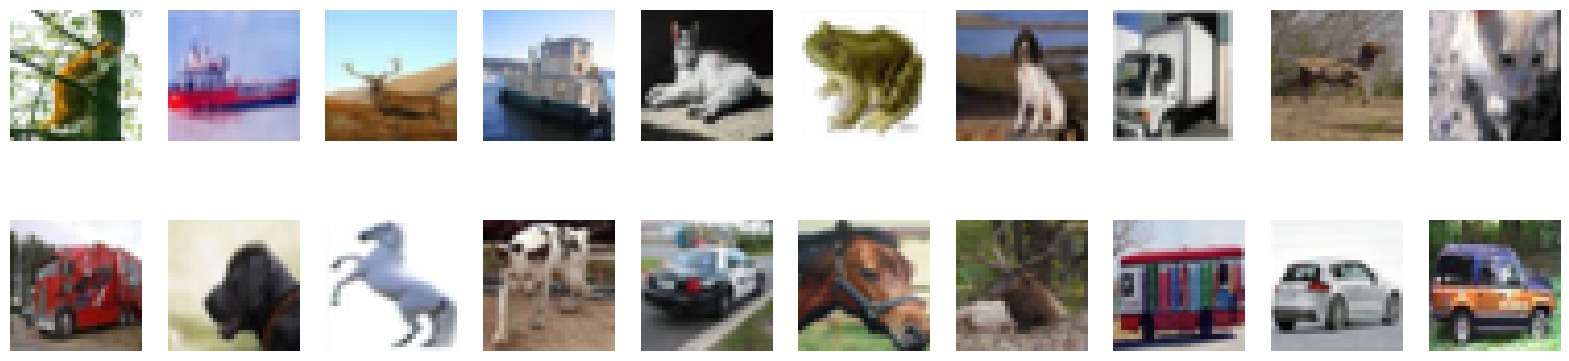

In [32]:
# 显示前20张图片

import numpy as np
import matplotlib.pyplot as plt

 # 指定图片大小，图像大小为20宽、5高的绘图(单位为英寸inch)
plt.figure(figsize=(20, 5)) 
for i, imgs in enumerate(imgs[:20]):
    # 维度缩减
    npimg = imgs.numpy().transpose((1, 2, 0))
    # 将整个figure分成2行10列，绘制第i+1个子图。
    plt.subplot(2, 10, i+1)
    plt.imshow(npimg, cmap=plt.cm.binary)
    plt.axis('off')
    
plt.show()  #如果你使用的是Pycharm编译器，请加上这行代码

下面创建了一个卷积神经网络。对于卷积神经网络，设计可以改变的参数很多，卷积和池化的层数，线性化的层数  
卷积核大小的选择，要不要填充边缘，卷积核移动的步长。卷积和池化层的次序，池化的大小。后面线性化的层数和神经元的数量。都是可以调整的参数。  
而且这些参数可能并没有绝对的规律可以追寻，很多靠经验和针对数据集的反复修改测试才能知道。   

In [33]:
import torch.nn.functional as F

num_classes = 10  # 图片的类别数

class Model(nn.Module):
     def __init__(self):
        super().__init__()
        
        # 特征提取网络
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)   # 第一层卷积,前层3通道输入，本层64个神经元，卷积核大小为3*3
        self.pool1 = nn.MaxPool2d(kernel_size=2)       # 设置池化层，池化核大小为2*2
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)  # 第二层卷积,前层64神经元输入，本层64个神经元，卷积核大小为3*3   
        self.pool2 = nn.MaxPool2d(kernel_size=2)       # 设置池化层，池化核大小为2*2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # 第二层卷积,前层64神经元输入，本层128个神经元，卷积核大小为3*3   
        self.pool3 = nn.MaxPool2d(kernel_size=2)       # 设置池化层，池化核大小为2*2
                                      
        # 分类网络
        # 因为最开始额图像是3*32*32的，使用64个3x3的卷积核卷积以后，输出数据少了周围一圈，成为64x30x30的
        # 再经过2x2的池化，成为64x15x15的
        # 又经过3x3的卷积，成为64x13x13的，再次2x2池化（向下取整），成为64x6x6的。
        # 然后下一个卷积层，成为128x4x4的，再次2x2池化，成为128x2x2的
        # 所以下面这个线性化的输入是512=128x4x4，输出256，再下一层线性化将256个输出对应到类别上
        self.fc1 = nn.Linear(512, 256)                 
        self.fc2 = nn.Linear(256, num_classes)
        
     # 前向传播
     def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))     
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       
        return x

显示一下模型的结构。可以看到，上面一个不算太复杂的卷积神经网络，总参数已经到了24万+，可以想象一个复杂一些的神经网络会是什么样子。

In [34]:
from torchinfo import summary
# 将模型转移到GPU中（我们模型运行均在GPU中进行）
model = Model().to(device)

summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Conv2d: 1-1                            1,792
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            36,928
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            73,856
├─MaxPool2d: 1-6                         --
├─Linear: 1-7                            131,328
├─Linear: 1-8                            2,570
Total params: 246,474
Trainable params: 246,474
Non-trainable params: 0

损失函数是拿来评估训练后的模型的准确程度的，选择不同的损失函数会 对结果有一定的影响。

下面的学习率**learn_rate** 是重要的模型超参数。它可以直接影响模型训练的收敛速度和最终准确率。在应用中需要不断调整实验才能找到最优解。

In [35]:
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数

learn_rate = 1e-2 # 学习率
opt        = torch.optim.SGD(model.parameters(),lr=learn_rate)

In [36]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小，一共60000张图片
    num_batches = len(dataloader)   # 批次数目，1875（60000/32）

    train_loss, train_acc = 0, 0    # 初始化训练损失和正确率
    
    for X, y in dataloader:      # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()    # grad属性归零
        loss.backward()          # 反向传播
        optimizer.step()         # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [37]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小，一共10000张图片
    num_batches = len(dataloader)          # 批次数目，313（10000/32=312.5，向上取整）
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

这里可以调整训练轮次（epoch），也可以调整前面提到的超参数learn_rate，看看对训练结果有什么影响。  

对于训练结果，可以看到Train数据集的准确率不断提高，但是对于测试集的准确率逐渐和训练集的结果发生分离。这是正常现象。  
随着测试轮次的增加，准确率的提高速度逐渐下降，甚至出现一些波动，当连续一些轮次准确率一直在波动不能再有提高，则说明这个模型的预测能力接近极限了。

这里如果训练了一次想修改参数重新训练的话，要回到上面执行过 model = Model().to(device) 这一句再重新开始训练。否则model没有重新初始化，还保存着刚刚训练的结果，实际是在上次训练结果上继续训练。（踩过坑才知道）

In [38]:
epochs     = 50
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print('Done')

Epoch: 1, Train_acc:13.7%, Train_loss:2.283, Test_acc:22.5%，Test_loss:2.183
Epoch: 2, Train_acc:25.0%, Train_loss:2.019, Test_acc:28.0%，Test_loss:1.985
Epoch: 3, Train_acc:34.2%, Train_loss:1.802, Test_acc:40.2%，Test_loss:1.650
Epoch: 4, Train_acc:41.5%, Train_loss:1.611, Test_acc:44.1%，Test_loss:1.547
Epoch: 5, Train_acc:45.4%, Train_loss:1.507, Test_acc:47.5%，Test_loss:1.482
Epoch: 6, Train_acc:48.5%, Train_loss:1.422, Test_acc:40.9%，Test_loss:1.658
Epoch: 7, Train_acc:51.6%, Train_loss:1.347, Test_acc:51.9%，Test_loss:1.344
Epoch: 8, Train_acc:54.3%, Train_loss:1.280, Test_acc:54.0%，Test_loss:1.313
Epoch: 9, Train_acc:56.5%, Train_loss:1.223, Test_acc:56.0%，Test_loss:1.244
Epoch:10, Train_acc:58.7%, Train_loss:1.169, Test_acc:56.9%，Test_loss:1.211
Epoch:11, Train_acc:60.5%, Train_loss:1.122, Test_acc:59.6%，Test_loss:1.135
Epoch:12, Train_acc:62.2%, Train_loss:1.078, Test_acc:59.9%，Test_loss:1.147
Epoch:13, Train_acc:63.7%, Train_loss:1.038, Test_acc:59.9%，Test_loss:1.163
Epoch:14, Tr

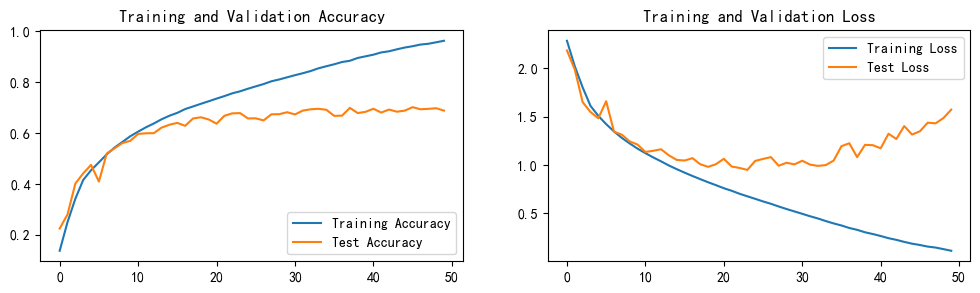

In [39]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               # 忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        # 分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()